Rare Event Binary Classification using Autoencoder 

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('processminer-rare-event-mts - data.csv')
df.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [4]:
display(df.shape)
one_indexes = df.index[df['y'] == 1]
display(one_indexes.shape)

(18398, 63)

(124,)

In [5]:
sign = lambda x: (1, -1)[x < 0]
def curve_shift(df, shift_by):
    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1
    return df

In [6]:
one_indexes = df.index[df['y'] == 1]
one_indexes.shape

(124,)

In [7]:
print('Before shifting')
df.iloc[(one_indexes[0]-3):(one_indexes[0]+4), 0:5].head()

Before shifting


,time,y,x1,x2,x3
256,5/1/99 8:32,0,1.016235,-4.058394,-1.097158
257,5/1/99 8:34,0,1.005602,-3.876199,-1.074373
258,5/1/99 8:36,0,0.933933,-3.868467,-1.249954
259,5/1/99 8:38,1,0.892311,-13.332664,-10.006578
260,5/1/99 10:50,0,0.020062,-3.987897,-1.248529


In [8]:
# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

In [9]:
print('After shifting')  # Validating if the shift happened correctly.
df.iloc[(one_indexes[0]-5):(one_indexes[0]+5), 0:5].head()

After shifting


,y,time,x1,x2,x3
254,0.0,5/1/99 8:28,0.975947,-3.913736,-1.304682
255,0.0,5/1/99 8:30,0.997107,-3.865720,-1.133779
256,0.0,5/1/99 8:32,1.016235,-4.058394,-1.097158
257,1.0,5/1/99 8:34,1.005602,-3.876199,-1.074373
258,1.0,5/1/99 8:36,0.933933,-3.868467,-1.249954


In [10]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

In [11]:
df.shape

(18274, 60)

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(1)
df_train, df_test = train_test_split(df, test_size=0.20, random_state=123)
df_train, df_valid = train_test_split(df_train, test_size=0.20, random_state=123)

In [13]:
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

In [14]:
df_valid_0_x.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
2587,-0.151683,-3.954797,-4.299529,62.011024,-0.096552,25.731026,-0.059389,-0.091023,-0.030057,0.001791,...,27.413823,11.055832,4.041316,-4.996629,-31.080624,60.825372,4.114269,0.011547,1.405894,0.007603
10042,-0.147111,-5.999036,14.114239,-22.551843,-0.051173,23.363014,0.138014,0.082431,-0.047305,-0.001783,...,29.984624,-8.220535,-2.140568,2.918754,32.183658,-14.610037,-1.470630,-0.149790,0.873270,-0.000131
18333,-1.001505,1.413677,0.772814,133.189490,-0.017313,24.688790,-0.159185,0.048752,0.150002,0.221829,...,29.984624,-0.773514,-0.752385,2.626903,10.084903,-38.972968,-1.345508,0.004998,0.196558,-0.011666
14917,-0.045711,-1.306390,-1.782303,109.723670,1.135503,-46.080543,0.020874,0.078965,0.451540,0.374269,...,29.984624,-3.672684,0.033504,0.643207,28.214908,-34.409476,-2.111499,0.003650,1.222185,0.001352
15653,0.087203,1.469594,-6.491958,220.912482,0.256597,28.408577,0.020874,0.008773,0.805514,0.871568,...,29.984624,-6.441238,6.044734,-4.822905,-81.990658,-38.172354,-4.137927,-0.006124,1.181757,-0.000550


In [15]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)

df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

In [16]:
display(df_train_0_x_rescaled)
display(df_valid_0_x_rescaled)
display(df_valid_x_rescaled)
display(df_test_0_x_rescaled)
display(df_test_x_rescaled)

array([[ 0.28465057, -0.40412757, -0.62589879, ...,  0.76290131,
         0.06550254,  0.83690695],
       [ 0.39664772, -0.62581965, -1.16135172, ...,  0.24624873,
         0.0433654 , -0.52066544],
       [-0.25231813,  0.8485702 , -0.77904894, ..., -0.05464438,
         0.52862848, -0.21522559],
       ...,
       [ 0.12948316, -0.40980764, -0.48081707, ...,  0.4773214 ,
         0.12223847,  0.66641167],
       [ 0.95893943, -0.01367991, -0.84227877, ...,  0.34469609,
         0.14765926, -0.31377229],
       [-0.652323  ,  0.11445042,  1.37973703, ...,  0.52270626,
         0.2442717 ,  1.19322293]])

array([[-0.2123079 , -0.84638099, -0.83541434, ...,  0.27188219,
         0.14545695,  1.35988685],
       [-0.20620535, -1.25804626,  2.26833326, ..., -3.05792872,
         0.09681695, -0.28631425],
       [-1.34637276,  0.23471291,  0.01955855, ...,  0.1367183 ,
         0.03501861, -2.74157399],
       ...,
       [ 1.07036275,  1.15176348, -0.29748802, ...,  0.47670224,
         0.05417028, -0.62368631],
       [-0.75209102,  2.51961398,  0.2989211 , ...,  0.69386432,
         0.11194919,  1.16384921],
       [ 0.50511518,  0.2391527 ,  0.3648576 , ...,  0.11352022,
         0.17010918, -1.00256471]])

array([[-0.2123079 , -0.84638099, -0.83541434, ...,  0.27188219,
         0.14545695,  1.35988685],
       [-0.20620535, -1.25804626,  2.26833326, ..., -3.05792872,
         0.09681695, -0.28631425],
       [-1.34637276,  0.23471291,  0.01955855, ...,  0.1367183 ,
         0.03501861, -2.74157399],
       ...,
       [ 1.07036275,  1.15176348, -0.29748802, ...,  0.47670224,
         0.05417028, -0.62368631],
       [-0.75209102,  2.51961398,  0.2989211 , ...,  0.69386432,
         0.11194919,  1.16384921],
       [ 0.50511518,  0.2391527 ,  0.3648576 , ...,  0.11352022,
         0.17010918, -1.00256471]])

array([[-0.03423556, -1.2896415 ,  2.10215425, ..., -0.99107074,
         0.02404451, -0.52534821],
       [-0.84889917, -0.95223909, -0.75813959, ...,  0.35759538,
         0.26804405,  1.45567072],
       [-0.55960368,  1.65781636,  1.1285587 , ...,  0.88351481,
         0.13074479,  1.43544968],
       ...,
       [ 0.61956509,  0.22911761,  0.1953567 , ...,  0.67326674,
         0.12002703,  0.40609241],
       [ 0.42553376, -0.26813482, -0.33340338, ...,  0.12350943,
         0.09839571, -0.01961366],
       [ 0.71178131, -0.02680998,  0.4402752 , ...,  0.19510563,
         0.12814112, -1.10154137]])

array([[-0.03423556, -1.2896415 ,  2.10215425, ..., -0.99107074,
         0.02404451, -0.52534821],
       [-0.84889917, -0.95223909, -0.75813959, ...,  0.35759538,
         0.26804405,  1.45567072],
       [-0.55960368,  1.65781636,  1.1285587 , ...,  0.88351481,
         0.13074479,  1.43544968],
       ...,
       [ 0.61956509,  0.22911761,  0.1953567 , ...,  0.67326674,
         0.12002703,  0.40609241],
       [ 0.42553376, -0.26813482, -0.33340338, ...,  0.12350943,
         0.09839571, -0.01961366],
       [ 0.71178131, -0.02680998,  0.4402752 , ...,  0.19510563,
         0.12814112, -1.10154137]])

In [17]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

C:\Users\Rupesh\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [18]:
df_train_0_x_rescaled.shape[1]

59

In [19]:
nb_epoch = 100
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Instructions for updating:
Use tf.cast instead.
Train on 11541 samples, validate on 2883 samples
Epoch 1/100
11541/11541 [==============================] - 2s 137us/step - loss: 2.6951 - acc: 0.0549 - val_loss: 2.2150 - val_acc: 0.0777
Epoch 2/100
11541/11541 [==============================] - 0s 16us/step - loss: 1.9105 - acc: 0.0756 - val_loss: 1.6011 - val_acc: 0.0663
Epoch 3/100
11541/11541 [==============================] - 0s 16us/step - loss: 1.4225 - acc: 0.0582 - val_loss: 1.2468 - val_acc: 0.0624
Epoch 4/100
11541/11541 [==============================] - 0s 16us/step - loss: 1.1667 - acc: 0.0646 - val_loss: 1.0713 - val_acc: 0.0704
Epoch 5/100
11541/11541 [==============================] - 0s 17us/step - loss: 1.0357 - acc: 0.0904 - val_loss: 0.9787 - val_acc: 0.1089
Epoch 6/100
11541/11541 [==============================] - 0s 16us/step - loss: 0.9621 - acc: 0.1301 - val_loss: 0.9225 - val_acc: 0.1391
Epoch 7/100
11541/11541 [==============================] - 0s 16us/step - 

Epoch 58/100
11541/11541 [==============================] - 0s 16us/step - loss: 0.6797 - acc: 0.4790 - val_loss: 0.6699 - val_acc: 0.4780
Epoch 59/100
11541/11541 [==============================] - 0s 16us/step - loss: 0.6788 - acc: 0.4812 - val_loss: 0.6659 - val_acc: 0.4745
Epoch 60/100
11541/11541 [==============================] - 0s 17us/step - loss: 0.6813 - acc: 0.4818 - val_loss: 0.6652 - val_acc: 0.4932
Epoch 61/100
11541/11541 [==============================] - 0s 16us/step - loss: 0.6791 - acc: 0.4832 - val_loss: 0.6713 - val_acc: 0.4690
Epoch 62/100
11541/11541 [==============================] - 0s 16us/step - loss: 0.6794 - acc: 0.4838 - val_loss: 0.6739 - val_acc: 0.4696
Epoch 63/100
11541/11541 [==============================] - 0s 16us/step - loss: 0.6855 - acc: 0.4772 - val_loss: 0.6616 - val_acc: 0.4842
Epoch 64/100
11541/11541 [==============================] - 0s 15us/step - loss: 0.6765 - acc: 0.4891 - val_loss: 0.6630 - val_acc: 0.4915
Epoch 65/100
11541/11541 [=

In [21]:
autoencoder = load_model('autoencoder_classifier.h5')

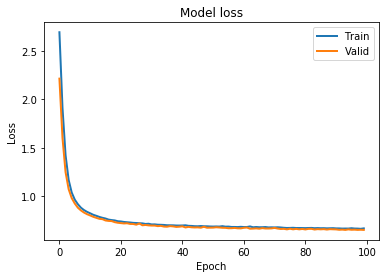

In [26]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

In [29]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)

In [30]:
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)

In [34]:
error_df = pd.DataFrame({'Reconstruction_error': mse,'True_class': df_valid['y']})
display(error_df.head())

,Reconstruction_error,True_class
2587,0.406427,0.0
10042,0.444691,0.0
18333,0.464381,0.0
14917,0.894546,0.0
15653,1.040202,0.0


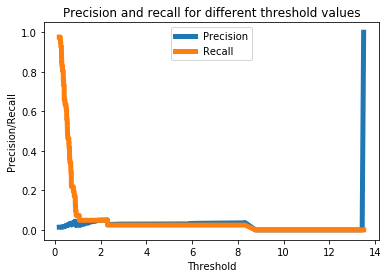

In [35]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [37]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()
error_df_test.head()

,index,Reconstruction_error,True_class
0,9735,0.449444,0.0
1,1997,0.536001,0.0
2,4121,0.377074,0.0
3,1888,0.628920,0.0
4,4040,0.564059,0.0


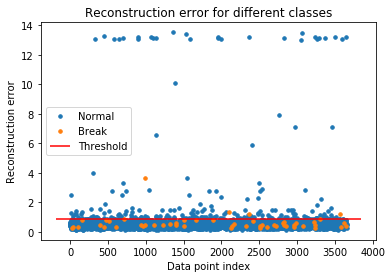

In [38]:
threshold_fixed = 0.85
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [42]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

In [43]:
predictions = pd.DataFrame({'true': error_df.True_class,
                           'predicted': pred_y})

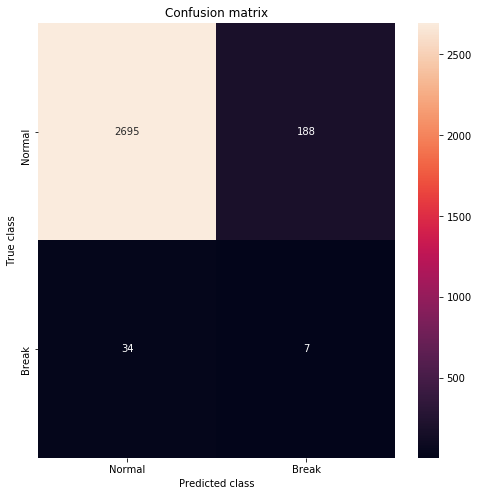

In [46]:
import seaborn as sns
#rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

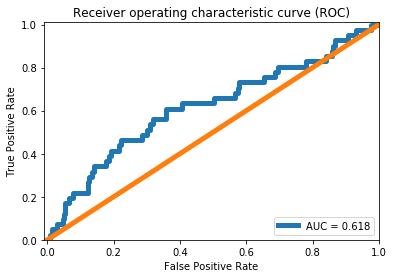

In [48]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()